# Interfacing with Stan
This notebook explains how it is possible to interface with [Stan](https://mc-stan.org/) to make use of their log-probability calculations, gradient calculation (via autodiff) and their large library of probability distributions.

One thing to be mindful of is that the interface below only allows the log probability to be accessed from Stan objects up to an additive constant.

In this notebook, we use the [Eight Schools example](http://pints.readthedocs.io/en/latest/toy/eight_schools.html) and show how the model can be defined in Stan but called from in Pints.

In [1]:
import pystan

Define Stan model using their syntax.

In [2]:
code="""
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta[J];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta ~ normal(mu, tau);
  y ~ normal(theta, sigma);
}
"""

Then compile Stan model (we also show code below to save the compiled model to avoid having to redo compilation).

In [3]:
import pickle
sm = pystan.StanModel(model_code=code)

# to pickle compiled model
with open('model.pkl', 'wb') as f:
    pickle.dump(sm, f)

# to load pickled compiled model
sm = pickle.load(open('model.pkl', 'rb'))

Import the Eight Schools ("centered" parameterisation) model from Pints: just to provide the data for fitting the Stan model in Pints.

In [4]:
import os
os.chdir("../..")
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.stats

model = pints.toy.EightSchoolsLogPDF()

Use the data provided with Pints' toy model to run Stan's NUTS for a few iterations (only needed so that we can access the functions bound to a stanfit object, so ignore warnings).

In [6]:
fit = sm.sampling(data=model.data(), iter=10, chains=1, verbose=True, refresh=10)

In [7]:
from collections import Counter
class StanLogPDF(pints.LogPDF):
    def __init__(self, stanfit, rectangular_boundaries=None):
        if not fit.__class__.__name__=='StanFit4Model':
            raise ValueError('Stan fit object must be of class StanFit4Model.')
        self._fit = stanfit
        self._log_prob = stanfit.log_prob
        self._grad_log_prob = stanfit.grad_log_prob
        self._u_to_c = stanfit.unconstrain_pars
        names = stanfit.unconstrained_param_names()
        self._n_parameters = len(names)
        self._names, self._index = self._initialise_dict_index(names)
        self._counter = Counter(self._index)
        self._dict = {self._names[i]: [] for i in range(len(self._names))}
        self._boundaries = None
        self._lower = None
        self._upper = None
        if rectangular_boundaries is not None:
            if not isinstance(rectangular_boundaries, pints.RectangularBoundaries):
                raise ValueError('Any boundaries must be of class `pints.RectangularBoundaries`.')
            if rectangular_boundaries.n_parameters() != self._n_parameters:
                raise ValueError('Dimensionality of boundaries must equal that of Stan fit.')
            self._boundaries = rectangular_boundaries
            self._lower = rectangular_boundaries.lower()
            self._upper = rectangular_boundaries.upper()
    
    def __call__(self, x):
        lower = self._lower
        upper = self._upper
        if lower is not None:
            for i, xs in enumerate(x):
                if xs < lower[i] or xs > upper[i]:
                    return -np.inf
        self._dict_update(x)
        return self._log_prob(self._u_to_c(self._dict), adjust_transform=True)

    def _dict_update(self, x):
        """ Updates dictionary object with parameter values. """
        names = self._names
        for i, name in enumerate(names):
            count = self._counter[i]
            if count == 1:
                self._dict[name] = x[i]
            else:
                vals = []
                for j in range(count):
                    vals.append(x[i + j])
                self._dict[name] = vals

    def evaluateS1(self, x):
        """ See :meth:`LogPDF.evaluateS1()`. """
        lower = self._lower
        upper = self._upper
        if lower is not None:
            for i, xs in enumerate(x):
                j = self._index[i]
                if xs < lower[j] or xs > upper[j]:
                    return -np.inf, self._boundaries.sample()
        self._dict_update(x)
        uncons = self._u_to_c(self._dict)
        return self._log_prob(uncons, adjust_transform=True), self._grad_log_prob(uncons, adjust_transform=True)

    def _initialise_dict_index(self, names):
        """ Initialises dictionary and index of names. """
        names_short = []
        for name in names:
            num = name.find(".")
            if num < 0:
                names_short.append(name)
            else:
                names_short.append(name[:num])
        names_long = list(names_short)
        names_short = list(dict.fromkeys(names_short))
        index = [names_short.index(name) for name in names_long]
        return names_short, index

    def n_parameters(self):
        return self._n_parameters

Run [relativistic HMC](../sampling/relativistic-mcmc.ipynb) sampler using this model. To do so, we first need to provide Pints with boundaries for each parameter, since Pints operates in the constrained space.

In [10]:
# initialise
xs = [np.random.normal(size=10) for chain in range(4)]
# set 1st element of each list to positive number since corresponds to a scale parameter
for x in xs:
    x[1] = np.random.uniform()

# Define boundaries for each parameter
# use a large value that extends much beyond typical range of distribution
max_val = 1000
upper = np.concatenate(([max_val, max_val], np.repeat(max_val, 8)))
lower = np.concatenate(([-max_val, 0], np.repeat(-max_val, 8)))
boundaries = pints.RectangularBoundaries(lower, upper)

# instantiate Pints version of Stan model
stanmodel = StanLogPDF(fit, rectangular_boundaries=boundaries)
    
mcmc = pints.MCMCController(stanmodel, len(xs), xs, method=pints.RelativisticMCMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(400)

# # Update step sizes used by individual samplers
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(0.2)

start = time.time()
# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')
end = time.time()

Running...
Using Relativistic MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     84     0.333     0.333     0.333     0.333      0:00.0
2     164    0.5       0.25      0.25      0.25       0:00.0
3     244    0.6       0.4       0.2       0.4        0:00.1
400   32004  0.876     0.826     0.846     0.811      0:06.7
800   64004  0.764     0.829     0.864     0.799      0:13.4
1200  96004  0.76      0.759     0.844426  0.8        0:20.0
1600  128004  0.745     0.732     0.846     0.817      0:26.6
2000  159924  0.751     0.717     0.827     0.822089   0:33.2
Halting: Maximum number of iterations (2000) reached.
Done!


In [11]:
results = pints.MCMCSummary(chains=full_chains, time=(end-start), parameter_names=fit.unconstrained_param_names())
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess    ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  -----  --------------
mu       1.93    2.26    -2.16   0.50   1.64   3.13   7.13     1.31    23.87  0.72
tau      3.04    2.22    0.51    1.60   2.50   3.63   9.48     1.23    64.35  1.94
theta.1  3.04    3.14    -1.97   0.95   2.48   4.62   10.52    1.11    31.08  0.93
theta.2  3.26    4.26    -4.49   0.81   2.42   5.27   14.44    1.22    30.45  0.92
theta.3  1.28    3.00    -5.11   -0.46  1.12   3.20   7.72     1.20    37.07  1.11
theta.4  1.35    2.81    -3.21   -0.81  1.12   3.04   7.72     1.57    50.45  1.52
theta.5  -0.40   4.64    -12.95  -1.73  0.61   2.38   6.49     1.47    38.13  1.15
theta.6  2.46    3.67    -3.90   -0.14  1.89   5.23   9.64     1.24    26.69  0.80
theta.7  3.35    3.81    -1.98   0.95   2.41   4.67   13.54    1.16    34.77  1.05
theta.8  2.34    3.25    -3.08   0.37   1.88   3.74   10.33    1.31  

The wandering chains here illustrate how difficult inference is for this model.

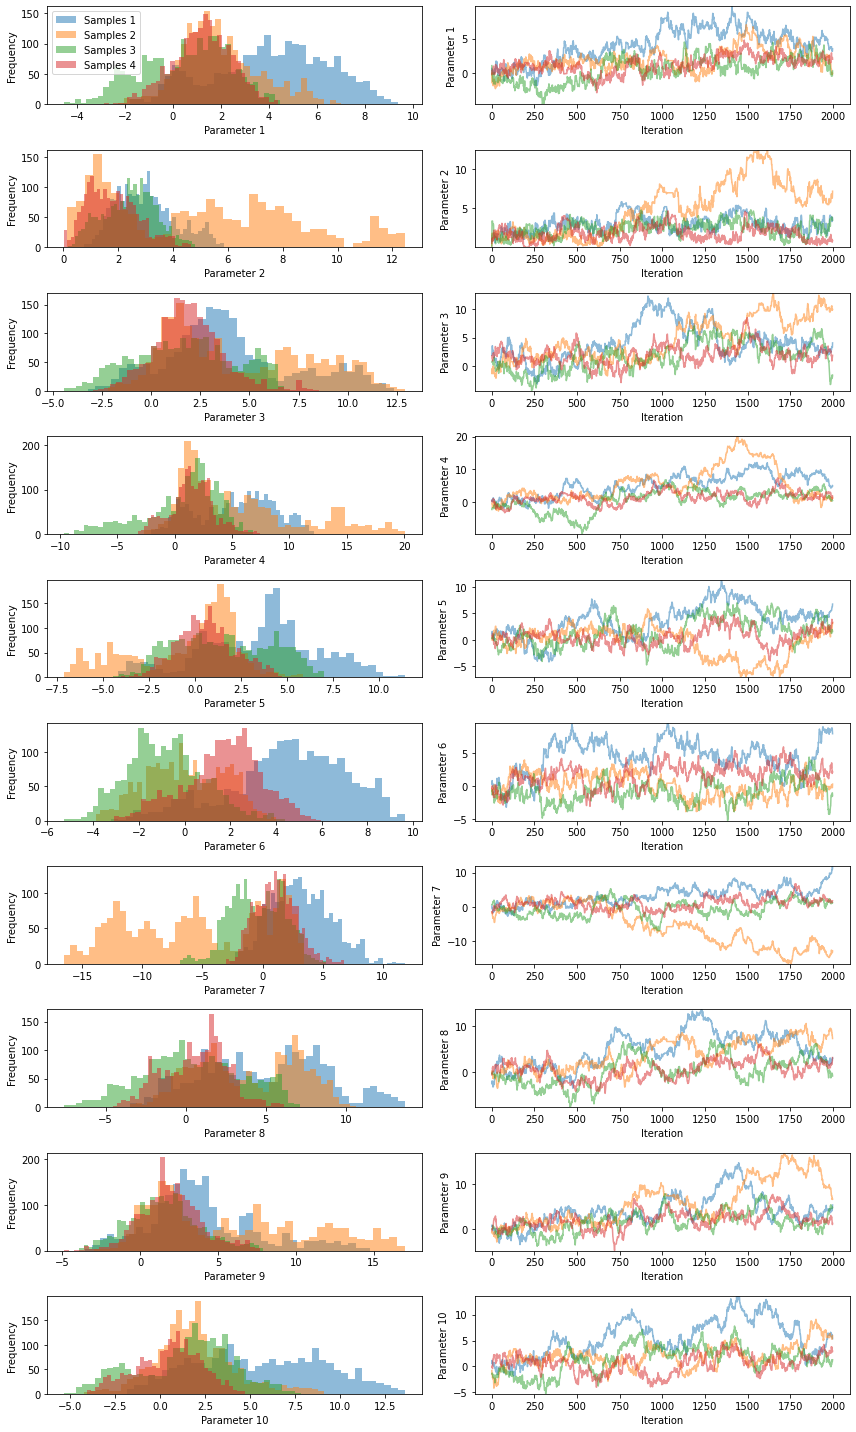

In [12]:
import pints.plot
pints.plot.trace(full_chains)
plt.show()

Just to hammer home the differences between Stan's log probability and Pints': we can compare them for sets of parameter values.

In [15]:
params = np.random.uniform(size=10)

pintsmodel = pints.toy.EightSchoolsLogPDF()

print(str("Stan log prob: " + str(stanmodel(params))))
print(str("Pints log prob: " + str(pintsmodel(params))))

Stan log prob: -160.84692893900126
Stan log prob: -160.84692893900126
Pints log prob: -197.08785278845127


The same goes for sensitivities!

In [17]:
p1, dp1 = stanmodel.evaluateS1(params)
p2, dp2 = pintsmodel.evaluateS1(params)

print(str("Stan d log(prob)/dmu: " + str(dp1[0])))
print(str("Pints d log(prob)/dmu: " + str(dp2[0])))

Stan d log(prob)/dmu: 621.017695585829
Stan d log(prob)/dmu: 621.017695585829
Pints d log(prob)/dmu: -0.010079932492943344


## Non-centered model

To speed things up, we can move to Stan's non-centered parameterisation. (Pints also has a version of this model: ) This model introduces auxillary variables $\tilde{\theta}_j$ which ensure the joint distribution: $p(\mu,\tau, \boldsymbol{\theta})$ remains the same, but is easier to sample from.

In [13]:
code="""
data {
  int<lower=0> J;
  real y[J];
  real<lower=0> sigma[J];
}

parameters {
  real mu;
  real<lower=0> tau;
  real theta_tilde[J];
}

transformed parameters {
  real theta[J];
  for (j in 1:J)
    theta[j] = mu + tau * theta_tilde[j];
}

model {
  mu ~ normal(0, 5);
  tau ~ cauchy(0, 5);
  theta_tilde ~ normal(0, 1);
  y ~ normal(theta, sigma);
}
"""

Compile Stan model and run it for a few iterations to get a stanfit object.

In [14]:
import pickle
sm = pystan.StanModel(model_code=code)

# to pickle compiled model
with open('model_ncp.pkl', 'wb') as f:
    pickle.dump(sm, f)

# to load pickled compiled model
sm = pickle.load(open('model_ncp.pkl', 'rb'))

# Run Stan model for a few iterations
fit = sm.sampling(data=model.data(), iter=10, chains=1, verbose=True, refresh=10)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3f8f9e8bb354ab461436bb51d935571d NOW.


Retry sampling, this time with the non-centered parameterisation.

In [16]:
# initialise
xs = [np.random.normal(size=10) for chain in range(4)]
# set 1st element of each list to positive number since corresponds to a scale parameter
for x in xs:
    x[1] = np.random.uniform()

# Define boundaries for each parameter
# use a large value that extends much beyond typical range of distribution
max_val = 1000
upper = np.concatenate(([max_val, max_val], np.repeat(max_val, 8)))
lower = np.concatenate(([-max_val, 0], np.repeat(-max_val, 8)))
boundaries = pints.RectangularBoundaries(lower, upper)

# instantiate Pints version of Stan model
stanmodel = StanLogPDF(fit, rectangular_boundaries=boundaries)

mcmc = pints.MCMCController(stanmodel, len(xs), xs, method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(2000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(200)

# # Update step sizes used by individual samplers
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(0.2)

start = time.time()
# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')
end = time.time()

Running...
Using Hamiltonian Monte Carlo
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     84     0.333     0.333     0.333     0.333      0:00.0
2     164    0.5       0.5       0.5       0.25       0:00.0
3     244    0.6       0.6       0.6       0.4        0:00.0
200   16004  0.891     0.837     0.916     0.876      0:02.8
400   32004  0.89801   0.833     0.905     0.893      0:05.6
600   48004  0.872093  0.776     0.909     0.914      0:08.3
800   64004  0.85      0.696     0.913     0.901      0:11.1
1000  80004  0.836     0.644     0.881     0.895      0:13.9
1200  96004  0.828619  0.646     0.852     0.901      0:16.6
1400  112004  0.793     0.652     0.831669  0.894      0:19.4
1600  128004  0.751     0.682     0.805     0.897628   0:22.1
1800  144004  0.729     0.708657  0.817     0.902      0:24.9
2000  159924  0.707     0.707     0.824     0.905    

Obtain $\theta_j = \mu + \tilde{\theta}_j \tau$.

In [17]:
full_chains_transformed = []
for i in range(len(full_chains)):
    mu = full_chains[i][:, 0]
    tau = full_chains[i][:, 1]
    theta_tilde_j = full_chains[i][:, 2:]
    full_chains_transformed.append(
        np.concatenate((np.transpose(np.vstack((mu, tau))),
                        mu[:, np.newaxis] + (theta_tilde_j * tau[:, np.newaxis])),axis=1))

Aaaaahh, that's better...

In [18]:
results = pints.MCMCSummary(chains=full_chains_transformed,
                            time=(end-start), parameter_names=names)
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
mu       4.02    3.18    -2.39   1.81   4.21   6.30   10.01    1.31    51.25   1.85
tau      7.20    4.10    0.99    4.02   6.48   10.46  16.44    1.27    44.66   1.61
theta.1  8.28    7.86    -4.67   3.08   7.31   12.52  26.64    1.02    139.18  5.02
theta.2  5.56    6.20    -6.91   1.69   5.33   9.36   18.80    1.03    250.10  9.03
theta.3  2.71    6.96    -11.71  -1.13  2.94   6.65   17.55    1.02    258.37  9.33
theta.4  4.96    6.00    -6.13   1.08   4.66   8.40   18.32    1.01    324.92  11.73
theta.5  2.19    5.56    -9.69   -1.16  2.76   5.79   12.15    1.05    236.96  8.55
theta.6  3.11    6.46    -11.24  -0.47  3.46   7.00   15.48    1.05    271.87  9.81
theta.7  8.46    6.94    -3.18   3.87   7.45   12.24  24.53    1.05    165.12  5.96
theta.8  5.47    7.78    -8.54   0.91   4.95   9.17   23.

...much more efficient sampling!

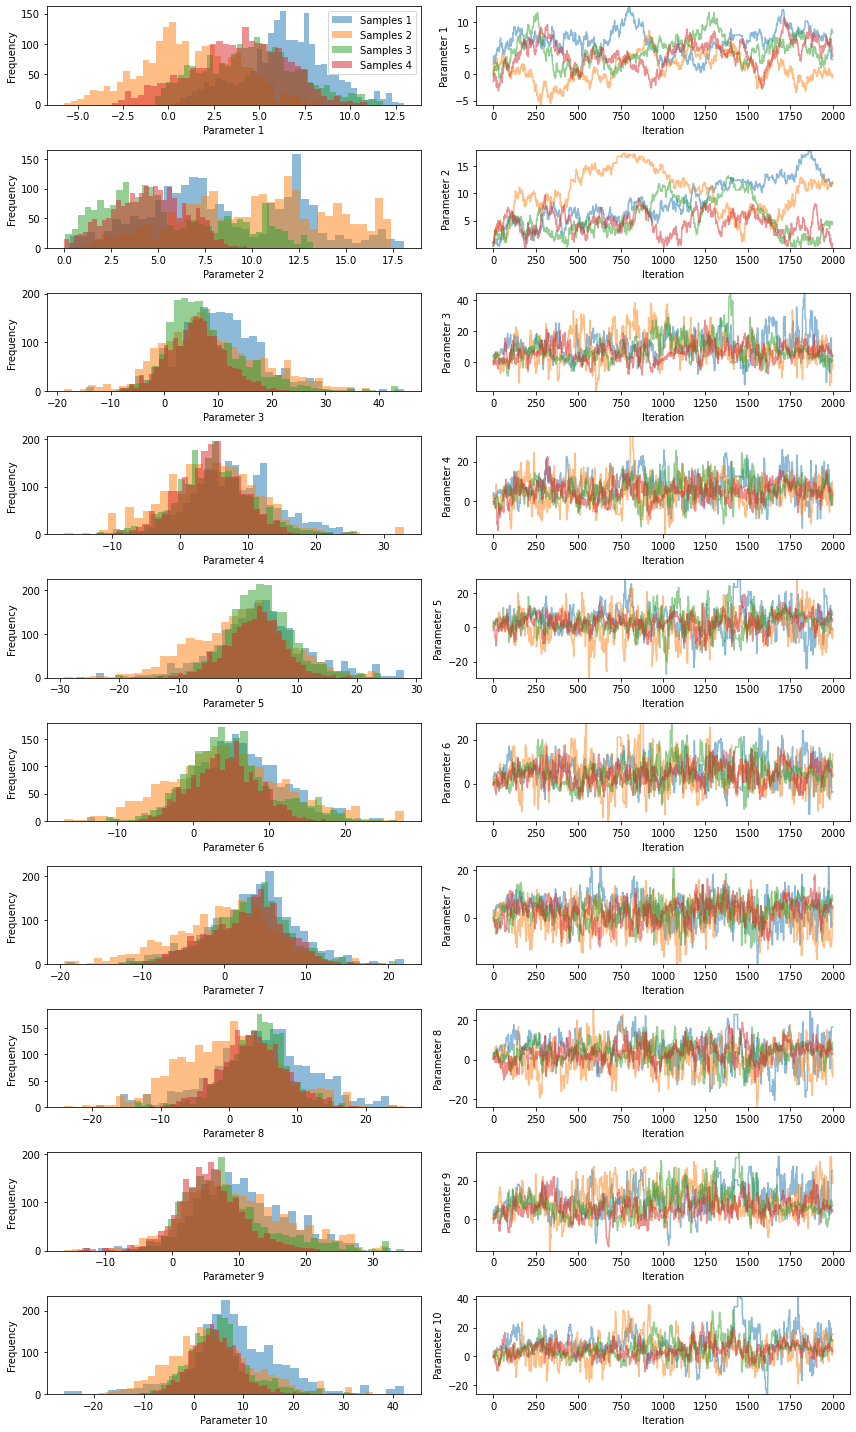

In [19]:
import pints.plot
pints.plot.trace(full_chains_transformed)
plt.show()